In [55]:
import numpy as np 
import pandas as pd 
import datetime as dt 
import yfinance as yf 
import matplotlib.pyplot as plt 
from scipy.stats import norm 

In [56]:
tickers = ['AAPL', 'MSFT', 'GOOGL']
data = yf.download(tickers, start='2020-01-01', end='2025-01-01')['Close']

[*********************100%***********************]  3 of 3 completed


In [57]:
returns = data.pct_change().dropna()

In [58]:
cov_matrix = returns.cov()

In [59]:
portfolio_value = 1_000_000
weights = np.array([1/3, 1/3, 1/3])  
positions = portfolio_value * weights

In [60]:
portfolio_var = np.dot(weights.T, np.dot(cov_matrix, weights))
portfolio_vol = np.sqrt(portfolio_var)

In [61]:
confidence_level = 0.99
z_score = norm.ppf(1 - confidence_level)  

In [62]:
VaR_1d = -z_score * portfolio_vol * portfolio_value  

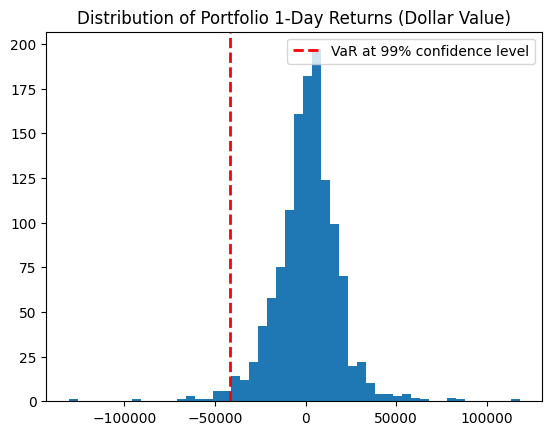

In [63]:
return_window = 1
plt.hist((returns*weights).sum(axis=1)*portfolio_value, bins = 50)
plt.axvline(-VaR_1d, c = 'r', linestyle='dashed', linewidth=2, label = f'VaR at {confidence_level:.0%} confidence level')  
plt.title(f'Distribution of Portfolio {return_window}-Day Returns (Dollar Value)')
plt.legend()

In [64]:
window = 250
portfolio_returns = returns.dot(weights)
rolling_cov = returns.rolling(window).cov().dropna()

VaR_roll = []
for i in range(window, len(returns)):
    cov_t = returns.iloc[i-window:i].cov()
    sigma_p = np.sqrt(np.dot(weights.T, np.dot(cov_t, weights)))
    VaR_roll.append(-z_score * sigma_p * portfolio_value)

VaR_roll = pd.Series(VaR_roll, index=returns.index[window:])


=== Backtest VaR 1j (variance-covariance, rolling_cov) ===
Tested period : 2020-12-30 → 2024-12-31
Days          : 1007
Exceptions     : 18 (1.79%) vs Expected ≈ 1.00%


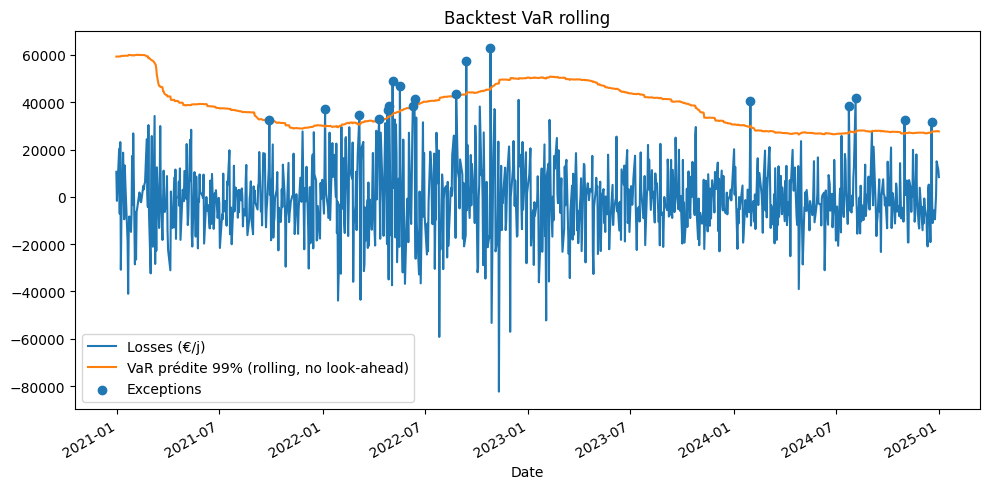

In [65]:
alpha = confidence_level        
z = norm.ppf(1 - alpha)


assets_order = returns.columns.tolist()
dates = rolling_cov.index.get_level_values(0).unique()

sigma_p = []
for d in dates:
    cov_t = rolling_cov.xs(d)      
    cov_t = cov_t.loc[assets_order, assets_order]
    sigma_p.append(np.sqrt(weights.T @ cov_t.values @ weights))

sigma_p = pd.Series(sigma_p, index=dates, name="sigma_p")


VaR_t = (-z) * sigma_p * portfolio_value
VaR_pred = VaR_t.shift(1).dropna()   


losses = -(portfolio_returns * portfolio_value)
losses_bt = losses.loc[VaR_pred.index]


violations = losses_bt > VaR_pred
freq = violations.mean()
expected = 1 - alpha

print("=== Backtest VaR 1j (variance-covariance, rolling_cov) ===")
print(f"Tested period : {losses_bt.index[0].date()} → {losses_bt.index[-1].date()}")
print(f"Days          : {len(violations)}")
print(f"Exceptions     : {int(violations.sum())} ({100*freq:.2f}%) "
      f"vs Expected ≈ {100*expected:.2f}%")


plt.figure(figsize=(10,5))
losses_bt.plot(label="Losses (€/j)")
VaR_pred.plot(label=f"VaR prédite {int(alpha*100)}% (rolling, no look-ahead)")
plt.scatter(losses_bt[violations].index, losses_bt[violations],
            label="Exceptions", zorder=3)
plt.title("Backtest VaR rolling")
plt.legend(); plt.tight_layout(); plt.show()

